In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
# import pdb
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
from get_mods import DART_Net, sep_ijkl_dataset

device = "cuda"

## Create DART Model

In [2]:
DART_model = DART_Net(128, 128, 256, 128, 32).to(device)

def init_params(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, a=1.0)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

DART_model.apply(init_params)

DART_Net(
  (fi1): Linear(in_features=3, out_features=128, bias=True)
  (fi2): Linear(in_features=128, out_features=128, bias=True)
  (fj1): Linear(in_features=3, out_features=128, bias=True)
  (fj2): Linear(in_features=128, out_features=128, bias=True)
  (fk1): Linear(in_features=3, out_features=128, bias=True)
  (fk2): Linear(in_features=128, out_features=128, bias=True)
  (fl1): Linear(in_features=3, out_features=128, bias=True)
  (fl2): Linear(in_features=128, out_features=128, bias=True)
  (inter1): Linear(in_features=128, out_features=256, bias=True)
  (inter2): Linear(in_features=256, out_features=128, bias=True)
  (inter3): Linear(in_features=128, out_features=32, bias=True)
  (inter4): Linear(in_features=32, out_features=1, bias=True)
  (mask): Linear(in_features=128, out_features=128, bias=False)
)

## Pre-processing of data

In [3]:
desc_data = sep_ijkl_dataset("../data/small_dataset.npz")

## Create Train:Validation:Test split  and dataloaders

In [4]:
validation_split = .1
test_split = .1
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(desc_data)
indices = list(range(dataset_size))
splitv = int(np.floor(validation_split * dataset_size))
splitt = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[splitt+splitv:], indices[:splitv], indices[splitv:splitt+splitv]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

trainloader = DataLoader(desc_data, batch_size=32, sampler=train_sampler)
validloader = DataLoader(desc_data, batch_size=32, sampler=valid_sampler)
testloader = DataLoader(desc_data, batch_size=32, sampler=test_sampler)

In [5]:
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(DART_model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=25, verbose=True, eps=1e-09)

## Training loop

In [6]:
epochal_train_losses = []
epochal_val_losses  = []
num_epochs = 1500
epoch_freq = 50
       
def test(DART_model, testloader):
    mae = torch.nn.L1Loss()
    rmse = torch.nn.MSELoss()
    pred_energy = torch.tensor([], device="cuda")
    real_energy = torch.tensor([], device="cuda")
    cluster_size = torch.tensor([], device="cuda")
    DART_model.eval()
    with torch.no_grad():
        for batch in testloader:
            energy = DART_model(batch["atm_i"], batch["atm_j"], batch["atm_k"], batch["atm_l"])
            energy = energy.sum(axis=1).squeeze(dim=1)
            pred_energy = torch.cat((pred_energy, energy))
            real_energy = torch.cat((real_energy, batch["energy"]))
            cluster_size = torch.cat((cluster_size, batch["atm_i"][:,0].sum(axis=1)))
        results = torch.stack((cluster_size, real_energy, pred_energy), axis=1)
        test_loss = mae(pred_energy, real_energy)
        rmse_loss = torch.sqrt(rmse(pred_energy, real_energy))
        print("Test MAE = ", test_loss.item(), "Test RMSE = ", rmse_loss.item())
        return results, test_loss, rmse_loss
    
def train(DART_model, optimizer, epochal_train_losses, criterion):
    train_loss = 0.00
    n = 0
    DART_model.train()
    for batch in trainloader:
        optimizer.zero_grad()
        energy = DART_model(batch["atm_i"], batch["atm_j"], batch["atm_k"], batch["atm_l"])
        energy = energy.sum(axis=1)
        batch_loss = criterion(energy, batch["energy"].unsqueeze(dim=1))
        batch_loss.backward()
        optimizer.step()
        
        train_loss += batch_loss.detach().cpu()
        n += 1
    train_loss /= n
    epochal_train_losses.append(train_loss)

def train_and_evaluate(DART_model, optimizer, scheduler, criterion, start_epoch=1, restart=None):
    if restart:
        restore_path = os.path.join(log_dir + "/last.pth.tar")
        checkpoint = load_checkpoint(restore_path, DART_model, optimizer)
        start_epoch = checkpoint["epoch"]

    best_val = 100000.00
    early_stopping_learning_rate = 1.0E-8
    
    for epoch in range(1, num_epochs+1):
        learning_rate = optimizer.param_groups[0]['lr']
        if learning_rate < early_stopping_learning_rate:
            break

        ############ training #############
        train(DART_model, optimizer, epochal_train_losses, criterion)
        
        ############ validation #############
        n=0
        val_loss = 0.0
        DART_model.eval()
        for batch in validloader:
            energy = DART_model(batch["atm_i"], batch["atm_j"], batch["atm_k"], batch["atm_l"])
            energy = energy.sum(axis=1)
            batch_loss = criterion(energy, batch["energy"].unsqueeze(dim=1))
            val_loss += batch_loss.detach().cpu()
            n += 1
        val_loss /= n
        epochal_val_losses.append(val_loss)
        scheduler.step(val_loss)
     
        is_best = val_loss <= best_val
        if epoch % epoch_freq == 0:
            print("Epoch: {: <5} Train: {: <20} Val: {: <20}".format(epoch, epochal_train_losses[-1], val_loss))

## Let's start training

In [7]:
train_and_evaluate(DART_model, optimizer, scheduler, criterion)

Epoch: 50    Train: 43.410823822021484   Val: 44.724998474121094  
Epoch: 100   Train: 37.868980407714844   Val: 40.430667877197266  
Epoch: 150   Train: 22.835939407348633   Val: 16.671171188354492  
Epoch: 200   Train: 27.785600662231445   Val: 18.455169677734375  
Epoch   213: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 250   Train: 5.5805888175964355   Val: 4.803256511688232   
Epoch: 300   Train: 4.708841323852539    Val: 5.64023494720459    
Epoch: 350   Train: 3.8772737979888916   Val: 8.492180824279785   
Epoch: 400   Train: 3.9091222286224365   Val: 3.4513983726501465  
Epoch   409: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 450   Train: 2.99368953704834     Val: 3.548546552658081   
Epoch   452: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 500   Train: 2.8055896759033203   Val: 3.3305866718292236  
Epoch   542: reducing learning rate of group 0 to 1.0000e-07.
Epoch: 550   Train: 2.766538143157959    Val: 3.336606025695801   
Epoch   568: re

## Testing the model on unseen data (test-set)

In [8]:
results, test_mae, test_rmse = test(DART_model, testloader)

Test MAE =  3.18778133392334 Test RMSE =  4.120918273925781


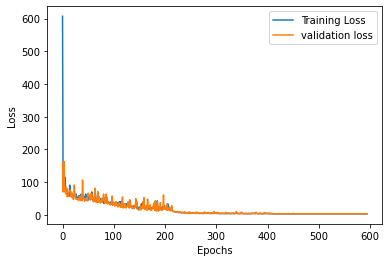

In [10]:
plt.plot(np.arange(0, len(epochal_train_losses), 1), epochal_train_losses, label='Training Loss')
plt.plot(np.arange(0, len(epochal_train_losses), 1), epochal_val_losses, label='validation loss')
plt.legend(loc='best')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

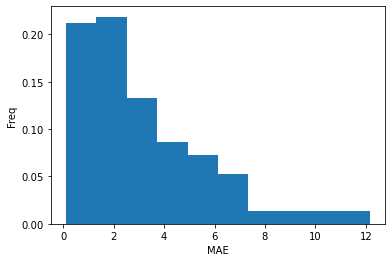

In [11]:
results = results[results[:,0].argsort()].cpu().numpy()
plt.hist(abs(results[:,1]-results[:,2]), density=True)
plt.xlabel("MAE")
plt.ylabel("Freq")
plt.show()

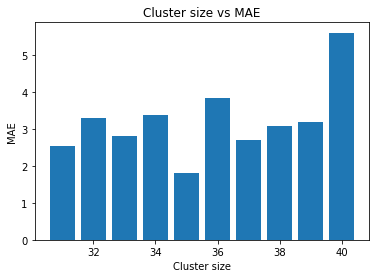

In [12]:
some_res = np.split(results[:,1:], np.unique(results[:, 0], return_index=True)[1][1:])
diff = [abs(i[:,0]-i[:,1]).mean() for i in some_res]
plt.title("Cluster size vs MAE")
plt.bar(np.arange(31, 41), diff, label='Training Loss')
plt.xlabel("Cluster size")
plt.ylabel("MAE")
plt.show()

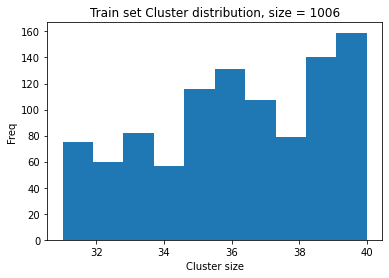

In [13]:
trainset = desc_data[train_indices]["atm_i"]
lol = trainset[:,0].sum(axis=1)
sizzle = [i.item() for i in lol]
plt.title("Train set Cluster distribution, size = {}".format(len(sizzle)))
plt.xlabel("Cluster size")
plt.ylabel("Freq")
plt.hist(sizzle, bins=10)
plt.show()
# plt.savefig("cluster_distribution_trainset.png", bbox_inches='tight')

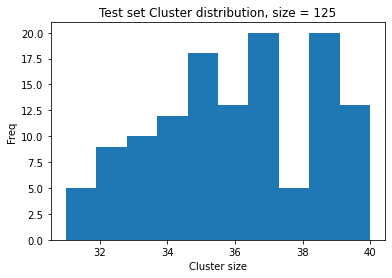

In [14]:
trainset = desc_data[test_indices]["atm_i"]
lol = trainset[:,0].sum(axis=1)
sizzle = [i.item() for i in lol]
plt.title("Test set Cluster distribution, size = {}".format(len(sizzle)))
plt.xlabel("Cluster size")
plt.ylabel("Freq")
plt.hist(sizzle, bins=10)
plt.show()
# plt.savefig("cluster_distribution_testset.png", bbox_inches='tight')

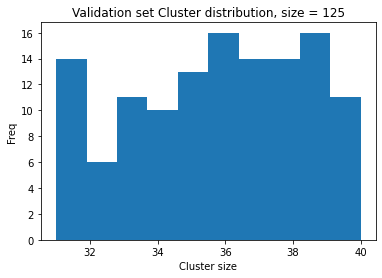

In [15]:
trainset = desc_data[val_indices]["atm_i"]
lol = trainset[:,0].sum(axis=1)
sizzle = [i.item() for i in lol]
plt.title("Validation set Cluster distribution, size = {}".format(len(sizzle)))
plt.hist(sizzle, bins=10)
plt.xlabel("Cluster size")
plt.ylabel("Freq")
plt.show()
# plt.savefig("cluster_distribution_validationset.png", bbox_inches='tight')